In [1]:
import numpy as np
import multiprocessing


import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
sns.set_style("ticks")
pd.set_option('display.max_columns', 500)

In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv("../../data/processed/cleaned_all_affiliations.csv.gz")
df.drop("Unnamed: 0",axis=1,inplace=True)

# Get the date of the affiliation and set the order of role affiliations

In [4]:
df.head()

,dept,disamb_org,oid,org_country,org_name,role,start_month,start_year,emp_or_edu,person_created_prof_date,person_first_name,person_last_mod_date,person_last_name,clean_role,role_category,clean_dept,gender_prob,row_index,fieldname,field_index,matched_field,field_term,matched_text,matchtype
0,NaN,12436 RINGGOLD,0000-0002-9666-480X,CN,NaN,NaN,7.0,2013.0,employment,2018-08-02T09:12:46.266Z,Rui,2018-08-02T09:12:46.499Z,Lu,NaN,NaN,NaN,0.9726775956284153,0,NaN,NaN,NaN,NaN,NaN,NaN
1,deptartamento evolutionary ecology,NaN,0000-0003-2971-080X,MX,NaN,Dr,9.0,2005.0,employment,2016-04-15T23:57:30.944Z,Karina,2016-04-15T23:57:30.944Z,Boege,dr,phd,deptartamento evolutionary ecology,0.004492027981960868,1,deptartamento evolutionary ecology,236336.0,evolutionary biology,evolutionary ecology,evolutionary biology,fuzzy_full_substring
2,dept. of physiology anatomy and genetics,6396 RINGGOLD,0000-0002-7291-080X,GB,NaN,NaN,NaN,NaN,employment,2016-04-15T22:59:44.629Z,Justin,2016-03-17T10:10:50.570Z,Hean,NaN,NaN,dept. of physiology anatomy and genetics,0.9950673219211867,2,dept. of physiology anatomy and genetics,9121.0,blacklist,anatomy,anatomy,full_substring
3,dept. of physiology anatomy and genetics,6396 RINGGOLD,0000-0002-7291-080X,GB,NaN,NaN,NaN,NaN,employment,2016-04-15T22:59:44.629Z,Justin,2016-03-17T10:10:50.570Z,Hean,NaN,NaN,dept. of physiology anatomy and genetics,0.9950673219211867,2,dept. of physiology anatomy and genetics,9121.0,blacklist,iology,biology,fuzzy_subword
4,dept. of physiology anatomy and genetics,6396 RINGGOLD,0000-0002-7291-080X,GB,NaN,NaN,NaN,NaN,employment,2016-04-15T22:59:44.629Z,Justin,2016-03-17T10:10:50.570Z,Hean,NaN,NaN,dept. of physiology anatomy and genetics,0.9950673219211867,2,dept. of physiology anatomy and genetics,9121.0,NaN,NaN,NaN,blacklist


In [5]:
from datetime import datetime
def get_date(x):
    if pd.isnull(x.start_year):
        return None
    if pd.isnull(x.start_month):
        try:
            return datetime(int(x.start_year),1,1)
        except:
            return None
    try:
        return datetime(int(x.start_year),int(x.start_month),1)
    except:
        return None
date = df.apply(get_date, axis=1)

In [6]:
df = df.assign(date_col = date)


In [7]:
df.shape[0], float(df[pd.isnull(df.date_col)].shape[0])/df.shape[0]

(6272006, 0.10272040556083652)

In [8]:
# order by date first, then role, then noting

role_order = {"bachelors" : 1,
              "masters/postgrad" : 2,
              "phd" : 3,
              "postdoc" : 4,
              "prof" : 5,
              "head" : 5}
df = df.assign(role_num=df.role_category.map(role_order))

In [9]:
df = df.sort_values(['oid','date_col','role_num'])

# Create clean dataset for initial analysis

In [10]:
clean_df = df.copy()

In [11]:
df.shape

(6272006, 26)

In [12]:
clean_df.columns

Index(['dept', 'disamb_org', 'oid', 'org_country', 'org_name', 'role',
       'start_month', 'start_year', 'emp_or_edu', 'person_created_prof_date',
       'person_first_name', 'person_last_mod_date', 'person_last_name',
       'clean_role', 'role_category', 'clean_dept', 'gender_prob', 'row_index',
       'fieldname', 'field_index', 'matched_field', 'field_term',
       'matched_text', 'matchtype', 'date_col', 'role_num'],
      dtype='object')

In [13]:
# Drop all affiliations where there was no department string
clean_df = clean_df[~pd.isna(clean_df.field_index)]

# Drop all affiliations where there is no first or last name
clean_df = clean_df[~(pd.isna(clean_df.person_first_name) & pd.isna(clean_df.person_last_name))]

# Drop all affiliations where there is no role or date
clean_df = clean_df[~(pd.isna(clean_df.date_col) & pd.isna(clean_df.role_num))]

In [14]:
clean_df.row_index.nunique()

3988331

In [15]:
clean_df.oid.nunique()

1617861

In [16]:
clean_df[clean_df.matchtype != 'no_match'].row_index.nunique()

2704493

In [17]:
# Drop all affiliations that didn't match any of our strings
clean_df = clean_df[clean_df.matchtype != 'no_match']

In [18]:
clean_df.row_index.nunique()

2704493

In [19]:
# get rid of cases where we're matching the same field twice (or the blacklist twice,
# we are going to get rid of those anyway
clean_df = clean_df[~clean_df.duplicated(subset=['row_index','matched_field'])]

In [20]:
clean_df.groupby('row_index').size().value_counts()

1    1998875
2     633817
3      68469
4       3210
5        114
6          7
7          1
dtype: int64

[Text(0, 0.5, 'Number of Affiliations'),
 Text(0.5, 0, 'Fields Per Affiliation')]

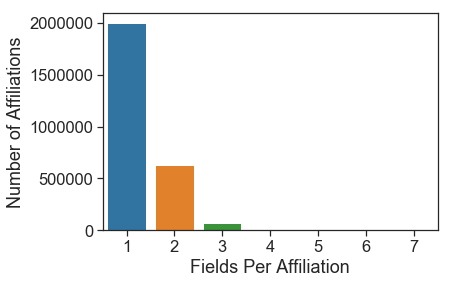

In [21]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

p = sns.barplot(x='N',y='count',
            data=clean_df.groupby('row_index').size()
            .value_counts()
            .reset_index()
            .rename(index=str, columns={"index":"N",0:"count"}))
p.set(xlabel="Fields Per Affiliation",ylabel='Number of Affiliations')


In [22]:
v = clean_df.groupby('row_index').size().value_counts().iloc[0]/clean_df.row_index.nunique()
print("{}% of the remaining matches are to exactly one of our fields or the blacklist".format(v))

0.7390941666330806% of the remaining matches are to exactly one of our fields or the blacklist


In [23]:
# Subset to those with only one match
size_id = clean_df.groupby('row_index').size()
rows_with_single_match = size_id[size_id == 1].index


In [24]:
clean_df = clean_df[clean_df.row_index.isin(rows_with_single_match)]

In [25]:
clean_df.shape

(1998875, 26)

In [26]:
v = clean_df[clean_df.matched_field != "blacklist"].shape[0]/clean_df.shape[0]
print("Of the single matches, {}% are to our fields, not the blacklist".format(v))

Of the single matches, 0.6991142517666187% are to our fields, not the blacklist


In [27]:
# Subset to non-blacklist matches
clean_df = clean_df[(clean_df.matched_field != "blacklist") & (clean_df.matchtype != "blacklist")]

In [28]:
clean_df.shape[0]

1274089

In [29]:
clean_df.groupby('matchtype').size().reset_index()

,matchtype,0
0,editdist,20725
1,exact_full,753633
2,full_substring,429631
3,fuzzy_full_substring,13287
4,fuzzy_subword,19902
5,subword,36911


[Text(0, 0.5, 'Number of Affiliations'), Text(0.5, 0, 'Type of Match')]

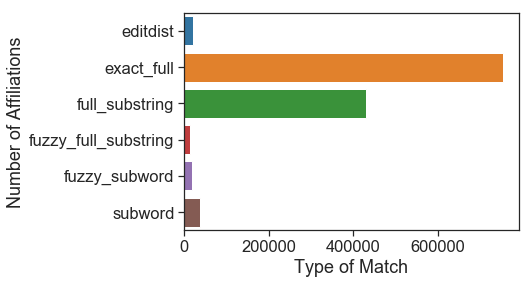

In [30]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

p = sns.barplot(y='N',x='count',
            data=clean_df.groupby('matchtype').size().reset_index()
                .rename(index=str, columns={"matchtype":"N",0:"count"}))
p.set(xlabel="Type of Match",ylabel='Number of Affiliations')

In [31]:
clean_df.to_csv("../../data/output/cleaned_singlematchtofield_affiliations.csv",index=False)

# Create Switches

In [32]:
df = clean_df

In [33]:
potential_switch_users = df.groupby("oid").size().reset_index()
potential_switch_users.columns = ['oid','cnt']
print(potential_switch_users[potential_switch_users.cnt > 1].shape)
print(potential_switch_users.shape)
potential_switch_users = potential_switch_users[potential_switch_users.cnt > 1]

(323687, 2)
(685650, 2)


In [34]:
df = df[df.oid.isin(potential_switch_users.oid)]

In [35]:
df.groupby("oid").size().value_counts()

2     180129
3      76335
4      36874
5      16521
6       7931
7       3405
8       1518
9        659
10       219
11        76
12        20
dtype: int64

In [36]:
df.oid.nunique()

323687

In [37]:
1-df[pd.isnull(df.date_col)].shape[0]/df.shape[0]

0.9614274782212107

In [38]:

def get_sorted(dat):
    # sort by year if we have that data
    date_sorted = dat[~pd.isnull(dat.date_col)].sort_values("date_col")
    other = dat[pd.isnull(dat.date_col)]
    # if we have dates for everything, yay! We're done!
    if len(date_sorted) == len(dat):
        return {"date_plus_role":date_sorted, "role_only":None}
    
    # maybe we have roles for everything?
    if len(other) == len(dat) and np.sum(pd.isnull(dat.role_num)) == 0:
        # cool. might not have switches for everything because role nums are 
        # equal, but we can at least sort on it
        return {"date_plus_role": other.sort_values("role_num"),
                "role_only" : None}
    
    #otherwise we have a mix of dates and no dates
    
    #if a row has no date and no role, we have to just drop it
    other = other[~pd.isnull(other.role_num)]
    
    # if there's nothing left, we're done
    if len(other) == 0:
        return {"date_plus_role":date_sorted,
                "role_only" : None}
    
    # otherwise, lets try to drop the role-defined indices into the date-defined indices
    role_rows_to_remove = []
    for other_row_iter, orv in enumerate(other.iterrows()):
        i, row_other = orv
        found_position = False
        for date_row_iter, dr in enumerate(date_sorted.iterrows()):
            j, row_date = dr
            if row_other['role_num'] <= row_date['role_num']:
                found_position = True
                break
        if found_position:
            role_rows_to_remove.append(i)
            date_sorted = (date_sorted.iloc[:date_row_iter]
                            .append(other.iloc[other_row_iter,:])
                            .append(date_sorted.iloc[date_row_iter:]))
            
    # drop the role rows we've managed to put into the date-sorted data
    other = other.drop(role_rows_to_remove)
    
    # at this point we've merged the dates and the roles data as best we can
    # if there's still role data left, we couldn't connect it to the date info
    # so we're gonna have to return both dataframes
    return {"date_plus_role" : date_sorted,
            "role_only" : other
            }

def field_set(f):
    #print f,  " set: ", set(f.split("||")) - {"NONE","REGEX",""}
    return set(f.split("||")) - {"NONE","REGEX",""}


gen_rows_to_incl = ['oid','person_first_name','person_last_name']#,'genni','ethnea','orcid']
per_col_to_incl = ['date_col','role_category','matched_field','matchtype','emp_or_edu','row_index','org_country','org_name']
def get_switches(ordered_deps):
    # *** Assumes pre-sorted!
    if ordered_deps is None:
        return []
    
    # The set approach isn't really necessary anymore but its fine to keep it
    switches = []
    for i, j in zip(range(len(ordered_deps)),range(1,len(ordered_deps))):
        #print set1, set2
        #if ordered_deps.matched_field.iloc[i] != ordered_deps.matched_field.iloc[j]:
            #print '\t switch'
        switches.append(ordered_deps.loc[ordered_deps.index[i],gen_rows_to_incl+per_col_to_incl].tolist() +
                        ordered_deps.loc[ordered_deps.index[j],per_col_to_incl].tolist())
        #else:
            #print '\t not switch'
    return switches
    

def sort_and_compute_switch(dat):
    # get sorted date+role and role-only dataframes
    sorted_dfs = get_sorted(dat)
    date_plus_role = sorted_dfs['date_plus_role']
    role_only = sorted_dfs['role_only']
    
    # get switches (if there possibly are any)
    return get_switches(date_plus_role) + get_switches(role_only)


In [39]:
switch_res = df.groupby("oid").apply(sort_and_compute_switch)

In [40]:
switches = pd.DataFrame([x for y in switch_res for x in y])

In [41]:
switches.columns = gen_rows_to_incl + ["from_"+x for x in per_col_to_incl] + ["to_"+x for x in per_col_to_incl]

In [42]:
switches.to_csv("../../data/output/all_switches_w_samefield.csv")

In [43]:
switches.shape

(583333, 19)